# DBN-project based on the EMNIST dataset
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import tensorflow as tf
from tensorflow import keras

import tqdm
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.util import random_noise

from DBN import DBN

We need to choose the device:

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


Let's implement a few functions for our convenience:

In [ ]:
def filter_data(data, targets, keep_labels=[1,2,3,4,5,6,7,8,9,10]):       #it is supposed that our model has 10 classes for classification
    idxs = [i for i in range(len(targets)) if targets[i] in keep_labels]
    return data[idxs], targets[idxs]

In [ ]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols, n_rows_cols, sharex = True, sharey = True, figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')


Now we upload the train and the test subsets from the EMNIST dataset, including only letters (uppercase and lowercase) by providing the argument split='letters'.

In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', split='letters', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize((0.1307,), (0.3081,))]  # here we use the mean and std computed on the MNIST training set
                                         ))

emnist_test = tv.datasets.EMNIST("data/", split='letters',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor(),
                                         tv.transforms.Normalize((0.1307,), (0.3081,))]
                                ))

Let's normalize the dataset and print its shape:

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

data_train, targets_train = filter_data(emnist_train.data, emnist_train.targets)
data_test, targets_test = filter_data(emnist_test.data, emnist_test.targets)
targets_train = targets_train - 1
targets_test = targets_test - 1

print(emnist_train.data.shape)
print(emnist_test.data.shape)
print(data_train.shape)
print(data_test.shape)
print(targets_train.shape)
print(targets_test.shape)

torch.Size([124800, 28, 28])
torch.Size([20800, 28, 28])
torch.Size([48000, 28, 28])
torch.Size([8000, 28, 28])
torch.Size([48000])
torch.Size([8000])


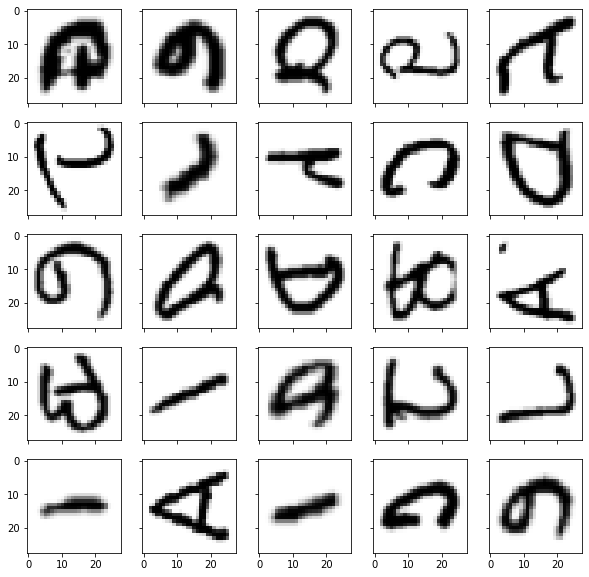

In [ ]:
visualize_symbols(
    data_train, n_subplots=25, image_shape=(28,28)
)

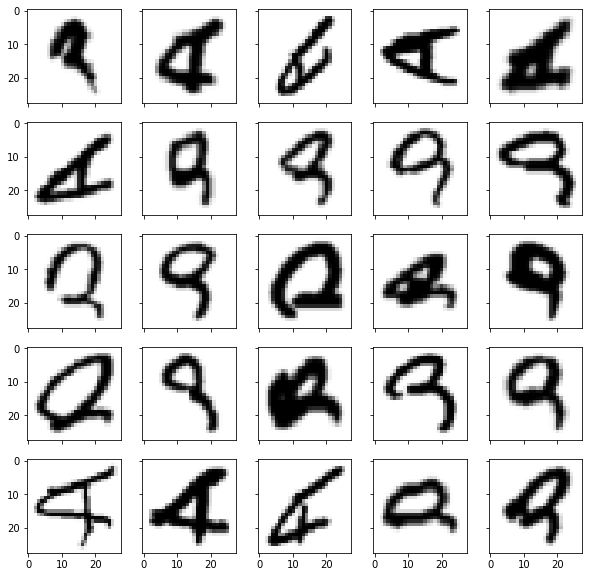

In [ ]:
visualize_symbols(
    data_test, n_subplots=25, image_shape=(28,28)
)

And now we send our data to the same device:

In [ ]:
data_train = data_train.to(device)
data_test = data_test.to(device)

targets_train = targets_train.to(device)
targets_test = targets_test.to(device)

#emnist_train.data = emnist_train.data.to(device)
#emnist_test.data = emnist_test.data.to(device)

#emnist_train.targets = emnist_train.targets.to(device)
#emnist_test.targets = emnist_test.targets.to(device)

#DBN
We'll start with our DBN model. First, we define it with the following parameters:

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 500, 700],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.0002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available()) 

Now let's train it:

In [ ]:
num_epochs = 40 #50
batch_size = 125 #100

dbn_emnist.train_static(
    data_train,
    targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2938     |0.0419       |313.3195   |6.7319     |
|20    |1.2079     |0.0389       |290.2575   |6.0828     |
|30    |1.1791     |0.0389       |282.6784   |5.8657     |
|40    |1.1640     |0.0355       |278.1887   |5.4012     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4998     |0.0403       |226.5565   |4.1422     |
|20    |1.3756     |0.0360       |218.4935   |3.7315     |
|30    |1.3548     |0.0358       |215.4884   |3.0285     |
|40    |1.3472     |0.0347       |215.2564   |3.5756     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2995     |0.0385       |251.0311   |5.4328     |
|20    |1.1624     |0.0331       |232.3680   |4.6822     |
|30    |1.1243     |0.0310       |227.2728   |4.1153     |
|40    |1.1057     |0.0305       |224.2401   |4.023

#Visualizing receptive fields
It is interesting to obtain some visualization of the learned weights. We will see which parts of an image trigger the unit associated with a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy. Finally, the values in different weigths could have different ranges, so we will rescale them using a $MinMaxScaler$ from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

Let's accomplish that by using the functions below.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100                             
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

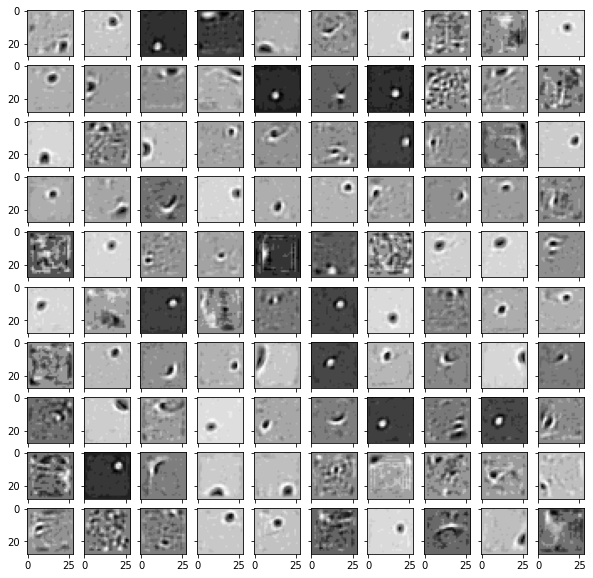

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers don't have the same dimensionality as the first one, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

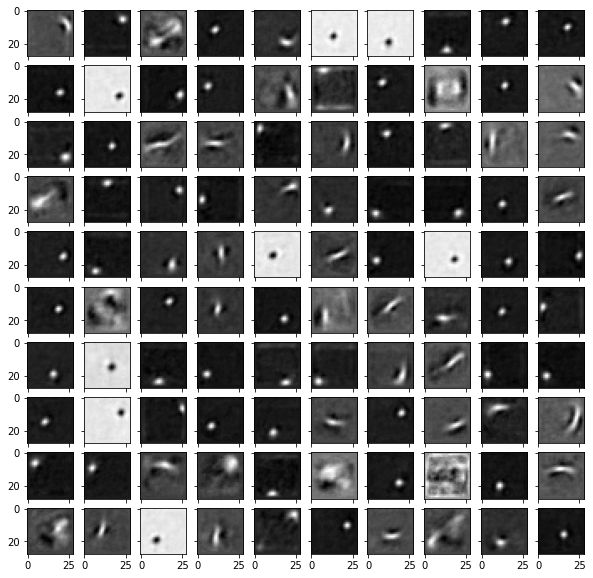

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

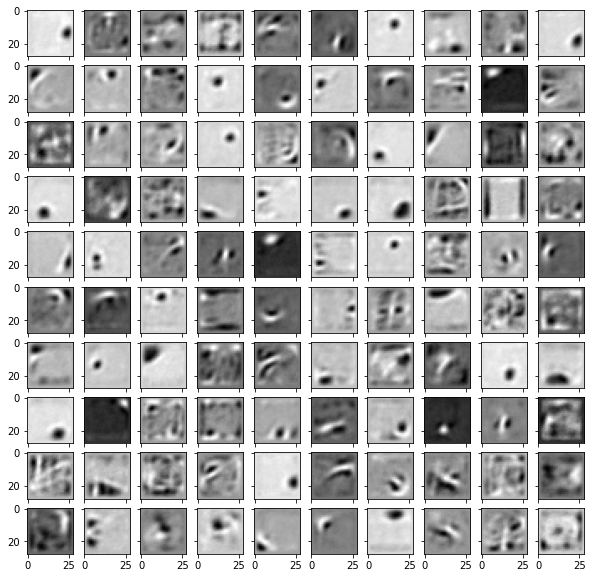

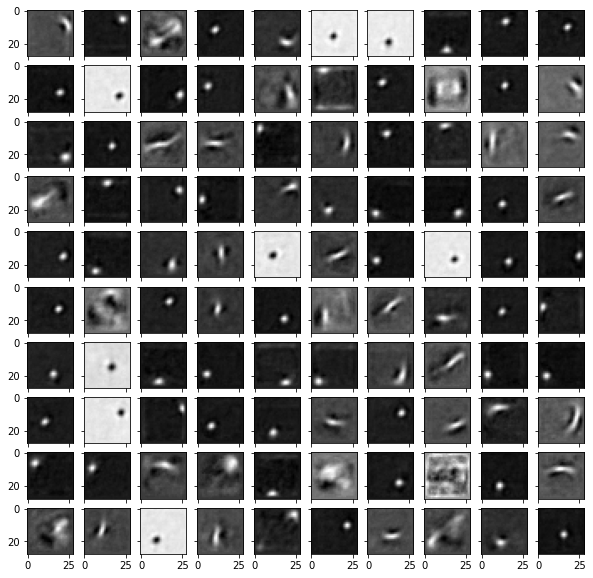

In [ ]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)
plot_layer_receptive_fields(learned_weights_12_product.T)

#Clustering internal representations

Now we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer:

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(data_train.data, 0, device) 
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = targets_train.cpu().numpy() 
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2) 
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now we can run the clustering algorithm and visualize its output in a dendrogram plot for the two layers.

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

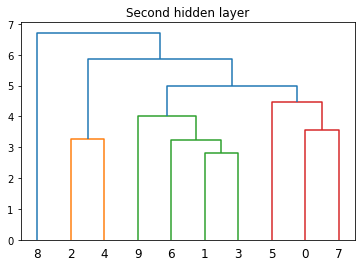

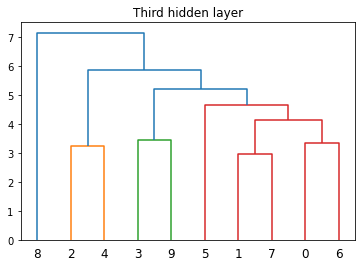

In [ ]:
np.nan_to_num(mean_hidd_repr_matrix_2, copy = False)
np.nan_to_num(mean_hidd_repr_matrix_3, copy = False)

plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")  
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

#Linear read-out

Now we make a linear readout of the representations computed by the `DBN` at each layer. This means that we will use the representations to classify the original images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation. Let's first define the class for the linear model:

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Then, we can instantiate a linear model for each layer of the `DBN`:

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the EMNIST dataset as targets:

In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = targets_train.reshape(predictions.shape[0]) # here are the labels 
    #targets = torch.tensor(emnist_train.targets).to(device).long().reshape(predictions.shape[0])
    #print(predictions.shape)
    #print(targets.shape)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_layer_1)
train_linear(linear2, hidden_repr_layer_2)
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.3248
epoch : 101/1500, loss = 0.9776
epoch : 201/1500, loss = 0.7915
epoch : 301/1500, loss = 0.7096
epoch : 401/1500, loss = 0.6603
epoch : 501/1500, loss = 0.6260
epoch : 601/1500, loss = 0.6001
epoch : 701/1500, loss = 0.5795
epoch : 801/1500, loss = 0.5625
epoch : 901/1500, loss = 0.5480
epoch : 1001/1500, loss = 0.5354
epoch : 1101/1500, loss = 0.5243
epoch : 1201/1500, loss = 0.5144
epoch : 1301/1500, loss = 0.5054
epoch : 1401/1500, loss = 0.4972
epoch :   1/1500, loss = 2.3588
epoch : 101/1500, loss = 0.9928
epoch : 201/1500, loss = 0.8035
epoch : 301/1500, loss = 0.7211
epoch : 401/1500, loss = 0.6718
epoch : 501/1500, loss = 0.6378
epoch : 601/1500, loss = 0.6122
epoch : 701/1500, loss = 0.5920
epoch : 801/1500, loss = 0.5753
epoch : 901/1500, loss = 0.5612
epoch : 1001/1500, loss = 0.5490
epoch : 1101/1500, loss = 0.5383
epoch : 1201/1500, loss = 0.5288
epoch : 1301/1500, loss = 0.5201
epoch : 1401/1500, loss = 0.5123
epoch :   1/1500, loss = 2.315

Let's now build the representation for the test set we kept apart at the beginning, and use them to evaluate the trained linear readouts:

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(data_test, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
#now we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Finally, let's compute the accuracy scores:

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
#here we compute the accuracy score for all 3 layers
print(compute_accuracy(predictions_test1, targets_test))
print(compute_accuracy(predictions_test2, targets_test))
print(compute_accuracy(predictions_test3, targets_test))

0.8526250123977661
0.8498750329017639
0.8683750629425049


Here we can see that the accuracy is roughly the same for all three layers, but slightly better for the third one.

#Feed-Forward model
Let's now train a simple feed-forward neural network with the same structure of the `DBN`, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an unsupervised way.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(500, 500, 700).to(device)

In [ ]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = targets_train.reshape(predictions.shape[0])  # here are the labels 
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

train(ffnn, data_train.reshape((48000, 784)), epochs=1500)

epoch :   1/1500, loss = 2.3015
epoch : 101/1500, loss = 2.2170
epoch : 201/1500, loss = 1.4750
epoch : 301/1500, loss = 0.9104
epoch : 401/1500, loss = 0.7377
epoch : 501/1500, loss = 0.6540
epoch : 601/1500, loss = 0.5959
epoch : 701/1500, loss = 0.5504
epoch : 801/1500, loss = 0.5115
epoch : 901/1500, loss = 0.4765
epoch : 1001/1500, loss = 0.4440
epoch : 1101/1500, loss = 0.4140
epoch : 1201/1500, loss = 0.3875
epoch : 1301/1500, loss = 0.3784
epoch : 1401/1500, loss = 0.3359


In [ ]:
predictions_ffnn = ffnn(data_test.reshape((8000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, targets_test)

0.8996250629425049

The accuracy seems to be approximately the same for both models.

Let's also plot the confusion matrix for the ffnn model:

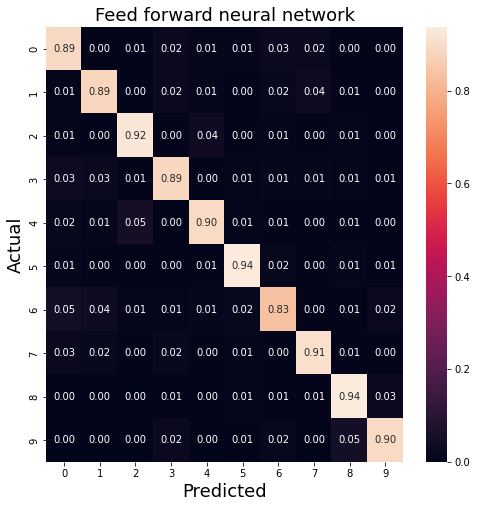

In [ ]:
def plot_confusion_matrix(ffnn_model, data, targets):
    predictions = ffnn_model(data.reshape((8000, 784)))
    predictions = predictions.max(axis=1).indices  # convert probabilities to indices
    
    conf_mat = confusion_matrix(
        targets.cpu().numpy(),
        predictions.cpu().detach().numpy(),
        labels = np.unique(targets.cpu().numpy()),
        normalize = 'true'
    )

    _, ax = plt.subplots(figsize = (8, 8))
    sns.heatmap(
        conf_mat, 
        annot = True, 
        fmt = '.2f',
        xticklabels=np.unique(targets.cpu().numpy()),
        yticklabels=np.unique(targets.cpu().numpy())
    )
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.title(f'Feed forward neural network', fontsize = 18)
    
plot_confusion_matrix(
    ffnn_model = ffnn,
    data = data_test,
    targets = targets_test
)


 Now we proceed with the noise impact study.

#Robustness to noise
We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [ ]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape, device = device)*noise_level 
  return data + random_gaussian_tensor

Let's see how different degrees of noise look like on the picture:

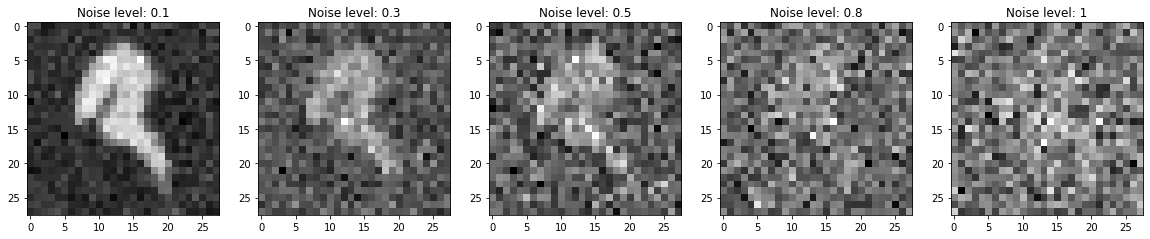

In [ ]:
#noise_level = 0.3
#data_test_with_noise = inject_noise(data_test, noise_level) #emnist_test_with_noise = ...#emnist_test.data
#__ = plt.imshow(data_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray") #emnist_test_with_noise

noise_level = [0.1, 0.3, 0.5, 0.8, 1]
data_test_with_noise = []
fig, axes = plt.subplots(1,5, figsize=(20,20))
for i in range(len(noise_level)):
  data_test_with_noise.append(inject_noise(data_test, noise_level[i])) #emnist_test_with_noise = ...#emnist_test.data
  axes[i].imshow(data_test_with_noise[i][0].reshape(28, 28).to("cpu"), cmap="gray") #emnist_test_with_noise
  axes[i].set_title("Noise level: {}".format(noise_level[i]))

We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  data_test_with_noise = inject_noise(data_test, noise_level)   # first, let's create noisy test images 
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(data_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, targets_test) 
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, targets_test) 
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, targets_test) 
  
  predictions_ffnn_noisy = ffnn(data_test_with_noise.reshape((8000, 784)))  # we repeat a similar process for the feed-forward model 
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, targets_test) 

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.819
Accuracy of H2 read-out: 0.836
Accuracy of H3 read-out: 0.861
Accuracy of FF network : 0.858


So, both of our models show similar behaviour with noisy data.

In [ ]:
print("Let's take a look at the accuracy for the same range of noise level\n")
for i in noise_level:
  print(f'For the noise level = {i} we obtain:')
  acc = get_accuracy_values_at_noise_level(i)
  #print("Accuracy of H1 read-out: %.3f" % acc[0])
  #print("Accuracy of H2 read-out: %.3f" % acc[1])
  print("Accuracy of H3 read-out: %.3f" % acc[2])
  print("Accuracy of FF network : %.3f" % acc[3])

Let's take a look at the accuracy for the same range of noise level

For the noise level = 0.1 we obtain:
Accuracy of H3 read-out: 0.868
Accuracy of FF network : 0.896
For the noise level = 0.3 we obtain:
Accuracy of H3 read-out: 0.861
Accuracy of FF network : 0.867
For the noise level = 0.5 we obtain:
Accuracy of H3 read-out: 0.834
Accuracy of FF network : 0.783
For the noise level = 0.8 we obtain:
Accuracy of H3 read-out: 0.741
Accuracy of FF network : 0.614
For the noise level = 1 we obtain:
Accuracy of H3 read-out: 0.651
Accuracy of FF network : 0.517


And here, as we can see, the higher the noise-level, the lower the accuracy we get, which is reasonable. Interestingly, with the level of noice $≈$ 0.6 and more, our ff model shows significantly worse performance than the DBN (we'll see it on the plot below).

Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network to visualize how well our models handle noise:

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots(figsize=(6,4))
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  ax.grid()
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

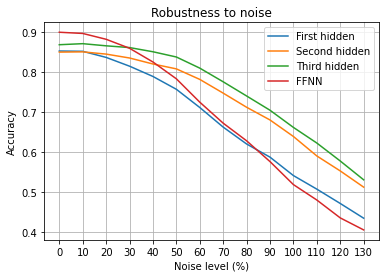

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

#Perturbing the models with adversarial attacks
In general, with adversarial attacks we try to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

We can take a look at how this adversarial attack looks like on the next example:

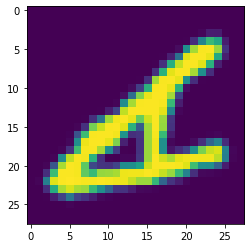

In [ ]:
test_sample_idx = 1
test_image = data_test[test_sample_idx].reshape(1, 784) #emnist_test.data
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the `model` variable in the cell below (choosing between `ffnn` and `dbn_with_readout`).

In [ ]:
attacked_model = ffnn

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 0.


Let's create and visualize the corresponding adversarial sample. The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

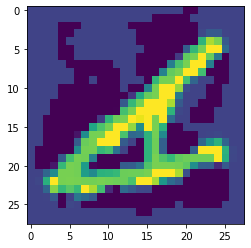

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = targets_test[test_sample_idx].unsqueeze(0)  # get ground truth label for that image #emnist_test.targets
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 7.


###Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)

        if init_pred.item() != target.item():   ###
            continue                            ###
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
#test_loader = torch.utils.data.DataLoader(
#    tv.datasets.EMNIST('data/', split='letters', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
#    batch_size=100, shuffle=True)

data = [[d, l] for d, l in zip(data_test, targets_test)]
test_loader = torch.utils.data.DataLoader(
    data,
    shuffle = True,
    batch_size = 1
)

Let's see how good the FFNN does:

In [ ]:
device = torch.device("cuda")
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 8000/8000 [00:13<00:00, 608.82it/s]


Epsilon: 0.1
Test Accuracy: 22.99%



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

100%|██████████| 8000/8000 [00:21<00:00, 368.79it/s]


Epsilon: 0.1
Test Accuracy: 66.68%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/8000 [00:00<?, ?it/s]


Here's the original sample:



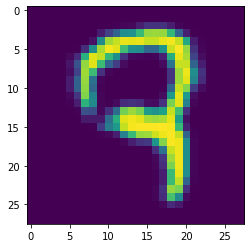


Here's a perturbed sample:



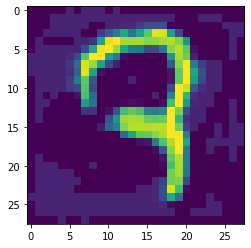


Here's what a 1-steps reconstructed sample looks like:



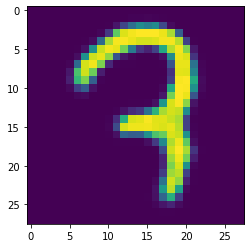

100%|██████████| 8000/8000 [00:36<00:00, 220.17it/s]


Epsilon: 0.1
Test Accuracy: 73.90%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

#Effect of the noise parameter $ϵ$
Finally, let's compare the robustness of each model to adversarial attacks of different "strengths":

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

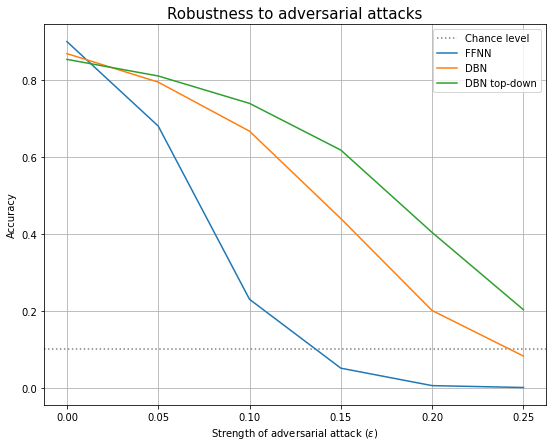

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])
__ = ax.grid()

###In addition - a CNN model for the EMNIST dataset

In [ ]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

data_train_np = data_train.cpu().numpy()
targets_train_np = targets_train.cpu().numpy()
data_test_np = data_test.cpu().numpy()
targets_test_np = targets_test.cpu().numpy()

history = model.fit(data_train_np, targets_train_np, epochs=5,
                    validation_data=(data_test_np, targets_test_np))

test_loss, test_acc = model.evaluate(data_test_np, targets_test_np, verbose=2)
print(test_acc)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)              

Accuracy happened to be very high for our CNN: 97%

In [ ]:
predictions = model.predict(data_test_np)

250/250 [==============================] - 1s 2ms/step


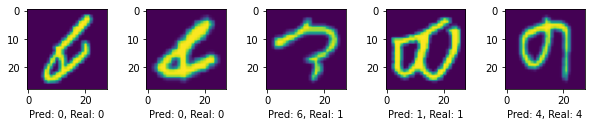

In [ ]:
numbers = [10, 100, 1000, 1001, 3381]

fig, axes = plt.subplots(1, len(numbers), figsize=(10,5))
for num in range(len(numbers)):
  axes[num].imshow(data_test_np[numbers[num]])
  axes[num].set_xlabel(f'Pred: {np.argmax(predictions[numbers[num]])}, Real: {targets_test_np[numbers[num]]}')

fig.subplots_adjust(wspace=0.5)

## Reference papers
- [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)